In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) #Display options for output
torch.set_grad_enabled(True) # Already on by default

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.5.1
0.6.1


In [3]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

**1 - Setting up the Network**

In [4]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  
  def forward(self,t):

    t = F.relu(self.conv1(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = F.relu(self.conv2(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = t.reshape(-1, 12 * 4 * 4)
    t = F.relu(self.fc1(t))

    t = F.relu(self.fc2(t))

    t = self.out(t)

    return t


  

**2. Loading the data**


In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    , train = True
    , download = True
    , transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

0.4%

100.0%

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


111.0%

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


100.0%

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


159.1%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


**3. Training the network**

In [ ]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr = 0.01)


for epoch in range(10):

  total_loss = 0
  total_correct = 0

  for batch in train_loader: #Get Batch
    images, labels = batch

    preds = network (images) #Pass batch
    loss = F.cross_entropy(preds, labels) #calculate loss

    optimizer.zero_grad()
    loss.backward()  #calculate gradients
    optimizer.step() #update weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

  print("epoch: {0}, Accuracy {1}, loss: {2}".format(epoch, total_correct/len(train_set), loss))

epoch: 0, Accuracy 0.7693833333333333, loss: 0.4671873152256012
epoch: 1, Accuracy 0.8502666666666666, loss: 0.3535434603691101
epoch: 2, Accuracy 0.8635666666666667, loss: 0.36855071783065796
epoch: 3, Accuracy 0.8712666666666666, loss: 0.33422964811325073
epoch: 4, Accuracy 0.8740833333333333, loss: 0.30830392241477966
epoch: 5, Accuracy 0.87705, loss: 0.30639559030532837
epoch: 6, Accuracy 0.8778666666666667, loss: 0.2543647885322571
epoch: 7, Accuracy 0.88025, loss: 0.2659085690975189
epoch: 8, Accuracy 0.8813, loss: 0.27023884654045105
epoch: 9, Accuracy 0.8835166666666666, loss: 0.26850950717926025


In [ ]:
total_correct/len(train_set)

0.8007166666666666

**4. Getting the predictions for the entire training set** 

In [ ]:
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds,preds)
        ,dim=0
    )
  return all_preds

In [ ]:
with torch.no_grad():
  prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
  train_preds = get_all_preds(network, prediction_loader)

In [ ]:
preds_correct = get_num_correct(train_preds, train_set.targets)

Building the confusion matrix

In [ ]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [ ]:
stacked.shape



torch.Size([60000, 2])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5495    5   74  107   21    3  250    0   45    0]
 [  25 5861    4   84    9    2    8    0    7    0]
 [ 113    2 4749   73  680    2  323    0   58    0]
 [ 228   16   11 5508  157    2   66    1    9    2]
 [  23    3  242  246 5189    1  274    0   22    0]
 [   1    0    0    0    0 5834    1   99   15   50]
 [1363    5  429  133  602    0 3379    2   87    0]
 [   0    0    0    0    0   82    2 5792    9  115]
 [  18    9    6   14   27    3   15    4 5904    0]
 [   0    0    0    0    0   34    0  214    6 5746]]


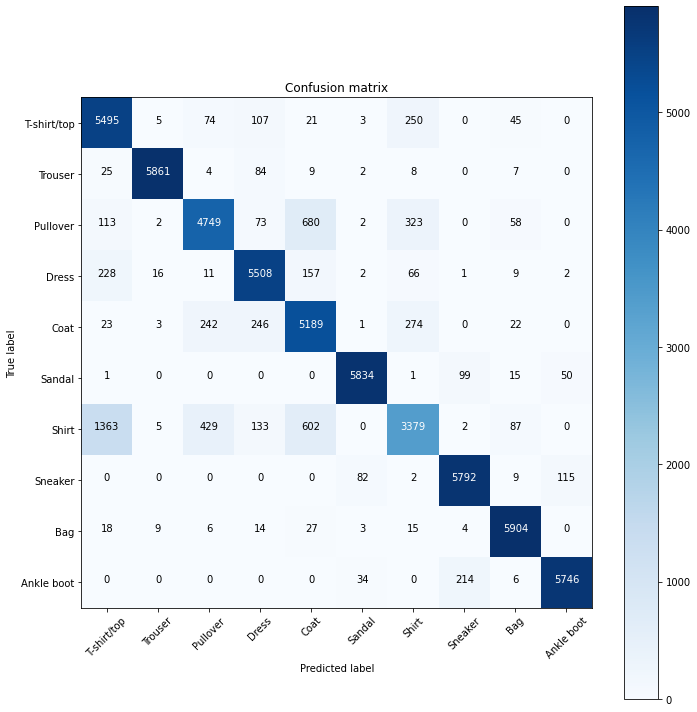

In [ ]:

import itertools


cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_set.classes)